In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
from mpl_toolkits.mplot3d import axes3d
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib notebook


def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)  # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name, index=index)
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name, index=index, size=size)
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name, index=str(index or '?'))

In [2]:
A = [-200, -100, -170, 15]
a = [-1, -1, -6.5, 0.7]
b = [0, 0, 11, 0.6]
c = [-10, -10, -6.5, 0.7]
xbar1 = [1, 0, -0.5, -1]
xbar2 = [0, 0.5, 1.5, 1]
xmin = -1.5
xmax = 1.5
ymin = -0.5
ymax = 2
stepRate = math.pow(10, -10)
stepSize = (abs(xmin) + abs(xmax)) * stepRate

In [3]:
def Vx(x1, x2, A, a, b, C, xbar1, xbar2):
    return np.sum([
        A[i] * np.exp((a[i] * (x1 - xbar1[i])**2) + (b[i] * (x1 - xbar1[i])) *
                      (x2 - xbar2[i]) + C[i] * (x2 - xbar2[i])**2)
        for i in range(len(A))
    ])


def move_new(x1, x2, mut_size, max_mut=1):

    x1_lst, x2_lst, new_score = [], [], []
    x_tups = np.array([(1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1),
                       (0, 1), (1, 1)])

    x_tup = get_coors(x1, x2, mut_size)

    new_x = (x_tups * x_tup) + (x1, x2)
    new_score = [Vx(x[0], x[1], A, a, b, c, xbar1, xbar2) for x in new_x]
    return new_score.index(min(new_score)), new_x[new_score.index(
        min(new_score))], min(new_score)


def get_coors(x1, x2, mut_size):

    new_x1 = abs(np.random.normal(0, mut_size, 1)[0])
    new_x2 = abs(np.random.normal(0, mut_size, 1)[0])
    qiv = 1.96 * mut_size

    if -qiv < new_x1 < qiv and -qiv < new_x2 < qiv:
        return new_x1, new_x2
    return get_coors(x1, x2, mut_size)


def getScheme_data(iters, plot="No"):
    linspace = np.linspace(0, 9, iters)
    answer = []

    for x in linspace:
        answer.append(0.5 +
                      math.erf((math.sqrt(math.pi) / 2) * (x - 2)) * -0.5)
    return answer


def mp_hillclimber(n_it, n_p, climb_scheme="Hillclimb"):
    if climb_scheme == "simAn": scheme = getScheme_data(n_it)
    xcoords = np.linspace(-0.85, 0.5, n_p)
    ycoords = np.linspace(1.35, 0.0, n_p)
    coords = [(x, y) for x, y in zip(xcoords, ycoords)]
    cur_coords = coords
    cur_scores = [Vx(x[0], x[1], A, a, b, c, xbar1, xbar2) for x in coords]
    cur_score = np.mean(cur_scores)
    coors_list = {"x": [xcoords], "y": [ycoords], "z": [cur_scores]}
    for i in range(n_it):
        new_coors, new_score = [], []
        for x1, x2 in cur_coords:
            new = move_new(x1, x2, mut_size=0.05)
            new_coors.append(new[1])
            new_score.append(new[2])
        if np.mean(new_score) < cur_score:
            cur_score = np.mean(new_score)
            cur_coords = new_coors
            coors_list["x"].append(list(np.array(new_coors)[:, 0]))
            coors_list["y"].append(list(np.array(new_coors)[:, 1]))
            coors_list["z"].append(new_score)
        elif climb_scheme == "simAn":
            if scheme[i] > np.random.uniform():
                cur_score = np.mean(new_score)
                cur_coords = new_coors
                coors_list["x"].append(list(np.array(new_coors)[:, 0]))
                coors_list["y"].append(list(np.array(new_coors)[:, 1]))
                coors_list["z"].append(new_score)

    return coors_list


data = mp_hillclimber(100, 6)

In [4]:
X = np.array(np.linspace(xmin, xmax, 200))
Y = np.array(np.linspace(ymin, ymax, 200))
Z = []

for x1 in X:
    temp = []
    for y1 in Y:
        V = Vx(x1, y1, A, a, b, c, xbar1, xbar2)
        if V > 100:
            temp.append(0)
        else:
            temp.append(V)
    Z.append(temp)
Z = np.array(Z)

In [5]:
def showPlot(i=0):
    print(X.shape, Y.shape, Z.shape)
    contours = plt.contour(X, Y, Z, 3, colors='black')
    plt.clabel(contours, inline=True, fontsize=8)

    plt.imshow(
        Z,
        extent=[np.min(X), np.max(X),
                np.min(Y), np.max(Y)],
        origin='lower',
        cmap='RdGy',
        alpha=0.7)
    plt.colorbar()
    for j in range(len(data["x"][i])):
        plt.scatter(data["x"][i][j], data["y"][i][j], c="b")
    plt.show


y = interactive(showPlot, i=(0, len(data["x"]) - 1, 1))
display(y)

interactive(children=(IntSlider(value=0, description='i', max=15), Output()), _dom_classes=('widget-interact',…

$$E(\mathbf{x}_0, \mathbf{x}_1, ..., \mathbf{x}_N) = \sum_{j=0}^N V(\mathbf{x}_j) + \frac12 k \sum_{j=1}^N \| \mathbf{x}_j-\mathbf{x}_{j-1} \|_2^2.$$

In [11]:
from sympy import *
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

A = [-200, -100, -170, 15]
a = [-1, -1, -6.5, 0.7]
b = [0, 0, 11, 0.6]
c = [-10, -10, -6.5, 0.7]
xbar1 = [1, 0, -0.5, -1]
xbar2 = [0, 0.5, 1.5, 1]
xmin = -1.5
xmax = 1.5
ymin = -0.5
ymax = 2
stepRate = math.pow(10, -10)
stepSize = (abs(xmin) + abs(xmax)) * stepRate

x1 = Symbol("x1")
x2 = Symbol("x2")
f = (-200 * exp((-1 * (x1 - 1)**2) +
                (0 * (x1 - 0)) * (x2 - 0) + -10 * (x2 - 0)**2)) + (-100 * exp(
                    (-1 * (x1 - 0)**2) + (0 * (x1 - 0)) * (x2 - 0.5) + -10 *
                    (x2 - 0.5)**2)) + (-170 * exp(
                        (-6.5 * (x1 - -0.5)**2) +
                        (11 * (x1 - -0.5)) * (x2 - 1.5) + -6.5 *
                        (x2 - 1.5)**2)) + (15 * exp(
                            (0.7 * (x1 - -1)**2) +
                            (11 * (x1 - -1)) * (x2 - 1) + 0.7 * (x2 - 1)**2))

fpx1 = f.diff(x1)
fpx2 = f.diff(x2)
grad = [fpx1, fpx2]

# Data
alpha = .0001
check = 0
precision = 1 / 1000000
printData = True
maxIterations = 1000


def gradient_descent(n_p):
    xcoords = np.linspace(-0.85, 0.5, n_p)
    ycoords = np.linspace(1.35, 0.0, n_p)
    x1Data = [xcoords]
    x2Data = [ycoords]
    VData = [[
        f.subs([(x1, xcoords[i]), (x2, ycoords[i])]).evalf()
        for i in range(len(xcoords))
    ]]

    for iterations in log_progress(range(maxIterations), every=1):
        temp_scores = []
        temp_theta = []
        temp_theta1 = []
        for i1, theta in enumerate(xcoords):
            theta1 = ycoords[i1]
            temptheta = theta - alpha * N(
                fpx1.subs(x1, theta).subs(x2, theta1)).evalf()
            temptheta1 = theta1 - alpha * N(fpx2.subs(x2, theta1)).subs(
                x1, theta).evalf()

            #If the number of iterations goes up too much, maybe theta (and/or theta1)
            #is diverging! Let's stop the loop and try to understand.
            if iterations + 1 > maxIterations:
                print(
                    "Too many iterations. Adjust alpha and make sure that the function is convex!"
                )
                printData = False
                return 1

            #If the value of theta changes less of a certain amount, our goal is met.
            if abs(temptheta - theta) < precision and abs(temptheta1 -
                                                          theta1) < precision:
                return x1Data, x2Data, VData, iterations

            #Simultaneous update
            temp_scores.append(
                f.subs([(x1, temptheta), (x2, temptheta1)]).evalf())
            temp_theta.append(temptheta)
            temp_theta1.append(temptheta1)

        xcoords = temp_theta
        ycoords = temp_theta1

        if np.mean(temp_scores) < np.mean(VData[-1]):
            x1Data.append(temp_theta)
            x2Data.append(temp_theta1)
            VData.append(temp_scores)


x1Data, x2Data, VData, iterations = gradient_descent(10)
print(len(x1Data), len(x2Data), len(VData))

Love and kisses <3
58 58 58


In [13]:
X = np.array(np.linspace(xmin, xmax, 200))
Y = np.array(np.linspace(ymin, ymax, 200))
Z = []

for x1val in X:
    temp = []
    for x2val in Y:
        V = Vx(x1val, x2val, A, a, b, c, xbar1, xbar2)
        if V > 100:
            temp.append(0)
        else:
            temp.append(V)
    Z.append(temp)
Z = np.array(Z)

def showPlot(i=0):
    contours = plt.contour(X, Y, Z, 3, colors='black')
    plt.clabel(contours, inline=True, fontsize=8)

    plt.imshow(
        Z,
        extent=[np.min(X), np.max(X),
                np.min(Y), np.max(Y)],
        origin='lower',
        cmap='RdGy',
        alpha=0.7)
    plt.colorbar()
    for j in range(len(x1Data[i])):
        plt.scatter(x1Data[i][j], x2Data[i][j], c="b")
    plt.show
    
if printData:
    print("The function "+str(f)+" converges to a minimum")
    print("Number of iterations:",iterations,sep=" ")
    print("best score =",min(VData[-1]),sep=" ")

y = interactive(showPlot, i=(0, len(x1Data) - 1, 1))
display(y)

The function -100*exp(-x1**2 - 10*(x2 - 0.5)**2) - 200*exp(-10*x2**2 - (x1 - 1)**2) - 170*exp(-6.5*(x1 + 0.5)**2 + (11*x1 + 5.5)*(x2 - 1.5) - 6.5*(x2 - 1.5)**2) + 15*exp(0.7*(x1 + 1)**2 + (11*x1 + 11)*(x2 - 1) + 0.7*(x2 - 1)**2) converges to a minimum
Number of iterations: 57
best score = -202.549511799576


interactive(children=(IntSlider(value=0, description='i', max=57), Output()), _dom_classes=('widget-interact',…

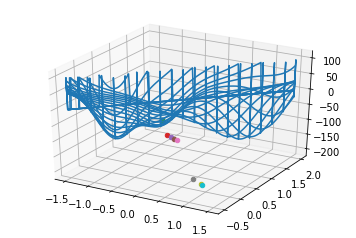

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
# %matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
for i in range(len(VData[-1])):
    ax.scatter(x1Data[-1][i], x2Data[-1][i], VData[-1][i], "b")
plt.show()

In [20]:
import numpy as np
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

def detect_local_minima(arr):
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    background = (arr==0)
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    detected_minima = local_min ^ eroded_background
    return np.where(detected_minima)

X = np.array(np.linspace(xmin, xmax, 200))
Y = np.array(np.linspace(ymin, ymax, 200))
Z = []

for x1val in X:
    temp = []
    for x2val in Y:
        V = Vx(x1val, x2val, A, a, b, c, xbar1, xbar2)
        if V > 100:
            temp.append(0)
        else:
            temp.append(V)
    Z.append(temp)
Z = np.array(Z)

Z[detect_local_minima(Z)][Z[detect_local_minima(Z)]<0]

array([-146.67901464,  -80.76687618, -108.16535922])